In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [2]:
def download(name, cache_dir = os.path.join('.', 'HouseData')):
    """如果name不存在于DATA_HUB，那就说明我们写错了name"""
    assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}"
    url, shal_hash = DATA_HUB[name]
    # exist_ok=True的意思是，如果要创建的目录已存在，那么就不用创建（这样防止抛出异常）
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        shal = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                shal.update(data)
        if shal.hexdigest() == shal_hash:
            return fname
    print(f"正在从{url}下载{fname}")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件夹"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all():
    for name in DATA_HUB:
        download(name)

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载.\HouseData\kaggle_house_pred_train.csv
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载.\HouseData\kaggle_house_pred_test.csv


In [7]:
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [11]:
# 取前四行的前四个和最后三个特征
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [14]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
print(all_features.shape)

(2919, 79)


In [27]:
# all_features.dtypes != 'object' 返回的是all_features当中数字为整数的那几列
# numeric_features当中保存的就是数字为整数的那几列的字段名（虽然是.index，但不是返回索引hh）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 注意：即使某一列有NaN，但只要该列其他元素是数字，那该列就不是object，下面这两行的先后顺序无所谓
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值。 这包括诸如“MSZoning”之类的特征。 我们用独热编码替换它们， 方法与前面将多类别标签转换为向量的方式相同。 例如，“MSZoning”包含值“RL”和“Rm”。 我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。 根据独热编码，如果“MSZoning”的原始值为“RL”， 则：“MSZoning_RL”为1，“MSZoning_RM”为0。 pandas软件包会自动为我们实现这一点。

In [32]:
print(all_features.shape)
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(2919, 331)
(2919, 331)


In [34]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [35]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [36]:
def log_rmse(net, features, labels):
    # 将预测值限制在1~infinity(float)之间，小于1的会被置成1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    # .item()返回的值更加精确
    return rmse.item()

In [37]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [39]:
# k折交叉验证，选择第i个切片作为验证数据，其余部分作为训练数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # 在python当中//是向下取整
    fold_size = X.shape[0] // k
    X_train, y_train = None,  None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # 在axis=0上拼接
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [40]:
# 当我们在k折交叉验证中训练k次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch',
                     ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170379,验证log rmse0.156246
折2，训练log rmse0.162447,验证log rmse0.189511
折3，训练log rmse0.163918,验证log rmse0.168343
折4，训练log rmse0.168273,验证log rmse0.154556
折5，训练log rmse0.162699,验证log rmse0.183010
折5，平均训练log rmse0.165543,平均验证log rmse0.170333


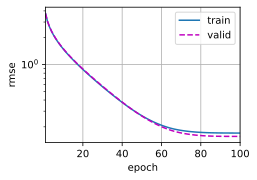

In [41]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'折{k}，平均训练log rmse{float(train_l):f},'
              f'平均验证log rmse{float(valid_l):f}')

训练log rmse: 0.162838


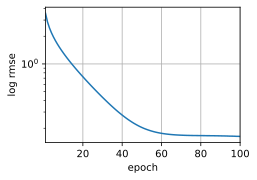

In [51]:
# 既然我们知道应该选择什么样的超参数， 我们不妨使用所有数据对其进行训练，而不是k折交叉验证当中的一部分数据
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse',
             xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    # preds本来是nx1维的，即这种：[[1],[2],[3]]，reshape(1,-1)变成了[[1,2,3]]，可以看到最外层多了一层括号，因此需要
    # reshape(1,-1)[0]将其变成[1,2,3]，这是一个很坑的地方，需要注意！
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./HouseData/submission.csv', index=False)
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)